<a href="https://colab.research.google.com/github/NataliaKurd/transformers_end_assignment/blob/main/transfomers_project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfomers: Exploration of memorization in Large Language Models

**Group members:**
- Natalia Kurdanova 1796550
- Jefry el Bhwash 9495495
- Sjardi Djoy Willems 7424442
- Sean van der Tuin 8087287

In [31]:
import numpy as np
import pandas as pd
import random
import tqdm
import re
import time

from google.colab import files

from matplotlib import pyplot as plt
from collections import Counter

from transformers import GPTNeoForCausalLM, GPT2Tokenizer, GenerationConfig
import torch

import nltk
from nltk.corpus import stopwords

In [33]:
# variables
# p = [50, 100, 150]
sequence_length = 200
p = 50
prompt_length = sequence_length - p

number_of_iterations = 10
save_every = 5
seed = 0

prompts_file_path = 'prompts_' + str(sequence_length) + '.npy'
counts_file_path = 'counts_' + str(sequence_length) + '.npy'

model_name = 'EleutherAI/gpt-neo-1.3B'

## 0. Download data

In [6]:
# add files required files to google colab, ( from repo https://github.com/ethz-spylab/lm_memorization_data)
data_p = np.load(prompts_file_path)
data_c = np.load(counts_file_path)

In [7]:
data_p.shape, data_c.shape

((53000, 200), (53000,))

In [8]:
data_p[199]

array([  276, 35067,   540,  5317,  5574, 25628,     7,    55,  9514,
           8,  5218,   513,    13,    18,    26,   198,   220,  8925,
        1441, 14253,   276, 35067,   540,    55,     7,    55,  9514,
           8,  5218,  1395,  9783,   198,   220,  8925,  1441, 14253,
         276,    55,     7,    55,  9514,     8,  5218,  1395,  9783,
         198,    92,   198,   198, 12417,  3419,  1391,   198,   220,
        2457,  3815,   796,   685, 29710,    16, 22784,  7308, 29710,
          17, 22784,  3834, 29710,    18,  3419, 11208,   628,   220,
        2457,   257,   796,  3815,    58,   600,    13, 29572, 10786,
          15, 11537,    60,   355, 34347,    16,    26,   198,   220,
        2457,   275,   796,  3815,    58,   600,    13, 29572, 10786,
          16, 11537,    60,   355,  7308, 29710,    17,    26,   198,
         220,  2457,   269,   796,  3815,    58,   600,    13, 29572,
       10786,    17, 11537,    60,   355,  3834, 29710,    18,    26,
         198,   220,

## 1. Data exploration

In [ ]:
data_prompts = data_p.copy()
data_counts = data_c.copy()

In [ ]:
vocab = GPT2Tokenizer.from_pretrained(model_name)

In [ ]:
decoded_data = []

for ids in tqdm.tqdm(data_prompts):
  decoded_data.append(vocab.decode(ids, skip_special_tokens=True))

100%|██████████| 53000/53000 [02:26<00:00, 362.74it/s]


In [ ]:
decoded_data = np.asarray(decoded_data)
decoded_data[199]

"edNullableIntOrDouble(X ignored) => 3.3;\n  dynamic returnBoxedNullableX(X ignored) => X();\n  dynamic returnBoxedX(X ignored) => X();\n}\n\nmain() {\n  final values = [Impl1(), BaseImpl2(), SubImpl3()];\n\n  final a = values[int.parse('0')] as Impl1;\n  final b = values[int.parse('1')] as BaseImpl2;\n  final c = values[int.parse('2')] as SubImpl3;\n  final d = values[int.parse('2')] as Interface;\n\n  a.takePositional(1, 1, 1.1, null, null, 1, null, null, X());\n  b.takePositional(2, 2, 2.2, 2, 2.2, 2.2, 2, X"

### 1.1. Data visualization

First we explor the data set with sequences of length 100. We will look at most frequent sequences and words.

In [ ]:
# top the most frequent sequences
sorted_freq = np.argsort(data_counts)[-50:]

In [ ]:
data_counts[sorted_freq]

array([144220, 144279, 144358, 144409, 144515, 144649, 144685, 144722,
       144895, 145201, 145209, 145336, 145478, 145499, 145701, 145724,
       145761, 145888, 145899, 145900, 146166, 146213, 146453, 146457,
       146596, 146712, 146833, 146835, 146998, 147019, 147199, 147255,
       147284, 147288, 147308, 147478, 147557, 147612, 147618, 147712,
       147792, 147803, 147928, 148004, 148020, 148078, 148095, 148106,
       148632, 149550])

In [ ]:
# We have duplicates because we do not have special tokens in the decoded data
print('Number of duplicated sequences: ', len(decoded_data) - len(set(decoded_data)))

Number of duplicated sequences:  17


In [ ]:
# clean the data
cleaned_data = []
regex_string = r'[^\w\s]|[\n]|(\s)(i|1|2|0|if|by|are|at|is|a|an|and|the|of|to|and|in|is|or|for|you|he|she|it|this|that|with|be|on)(\s)'

for sequence in tqdm.tqdm(decoded_data):
  sequence = sequence.lower()
  cleaned_data.append(re.sub(regex_string, ' ', sequence))

100%|██████████| 53000/53000 [00:02<00:00, 18430.46it/s]


In [ ]:
cleaned_data = np.asarray(cleaned_data)
cleaned_data[199]

'ednullableintordouble x ignored     3 3    dynamic returnboxednullablex x ignored     x      dynamic returnboxedx x ignored     x       main       final values    impl1    baseimpl2    subimpl3        final   values int parse  0    as impl1    final b   values int parse  1    as baseimpl2    final c   values int parse  2    as subimpl3    final d   values int parse  2    as interface     a takepositional 1  1  1 1  null  null  1  null  null  x       b takepositional 2  2  2 2  2  2 2  2 2  2  x'

In [ ]:
df = pd.DataFrame(cleaned_data)
df['Length'] = df[0].apply(len)
df['Word_Count'] = df[0].str.split().apply(len)

In [ ]:
df.sort_values(by='Word_Count', ascending=False).head(15)

,0,Length,Word_Count
35928,text text text text text text text text text ...,1000,200
24997,11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 ...,711,200
24707,37 38 39 30 31 32 33 34 35 36 37 38 39 30 31 ...,600,200
52946,000 000 000 000 000 000 000 000 000 000 000 0...,800,200
42847,00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 ...,600,200
52277,drip drip drip drip drip drip drip drip drip ...,1000,200
45601,3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3...,400,200
45572,x x x x x x x x x x x x x x x x x x x x x x x...,400,200
43455,very very very very very very very very very ...,1000,200
27310,42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 ...,570,190


In [ ]:
df.describe()

,Length,Word_Count
count,53000.000000,53000.000000
mean,466.575302,55.710660
std,189.598212,36.580895
min,51.000000,0.000000
25%,320.000000,27.000000
50%,432.000000,50.000000
75%,596.000000,82.000000
max,1600.000000,200.000000


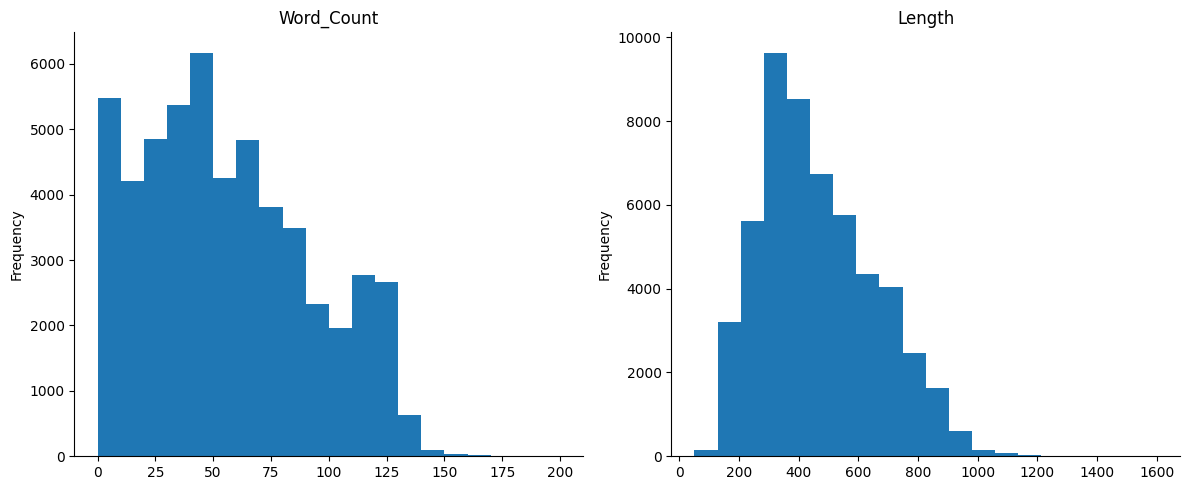

In [ ]:
# word count and lenght of the sequences

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

df['Word_Count'].plot(kind='hist', bins=20, title='Word_Count', ax=axes[0])
axes[0].spines[['top', 'right']].set_visible(False)

df['Length'].plot(kind='hist', bins=20, title='Length', ax=axes[1])
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
#plt.savefig('word_count.png')
plt.show()

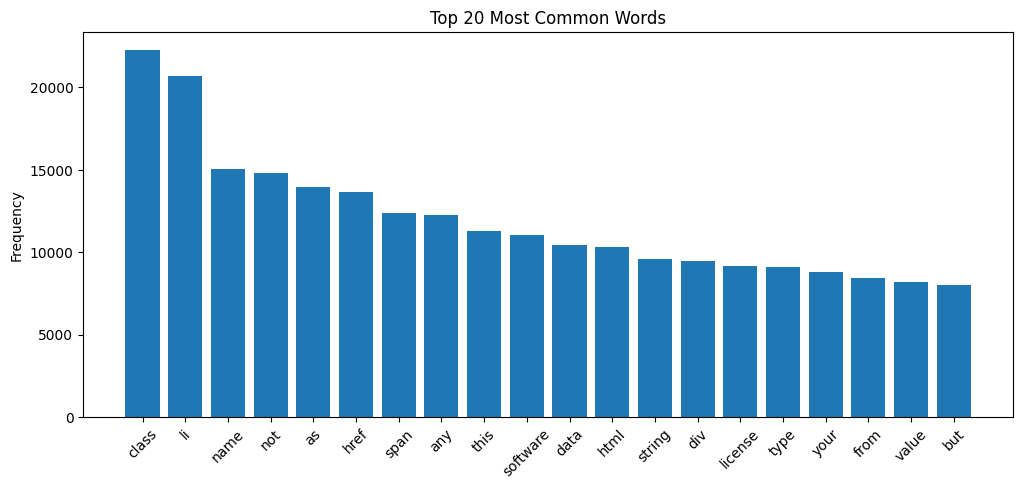

In [ ]:
# most common words

all_words = [word for sentence in df[0] for word in sentence.split() if not word in ['the', '0', 'a', '1', '2', 'i', 's', 'you', 'is']]
word_counts = Counter(all_words)

top_n = 20
most_common_words = word_counts.most_common(top_n)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
#plt.savefig('top_words.png')
plt.show()

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_sentence = [w for w in all_words if not w.lower() in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('class', 22241), ('li', 20680), ('name', 15033), ('href', 13658), ('span', 12370), ('software', 11036), ('data', 10432), ('html', 10319), ('string', 9598), ('div', 9457), ('license', 9191), ('type', 9078), ('value', 8214), ('use', 7869), ('3', 7714), ('n', 7150), ('â', 7040), ('nbsp', 7001), ('td', 6768), ('com', 6609)]


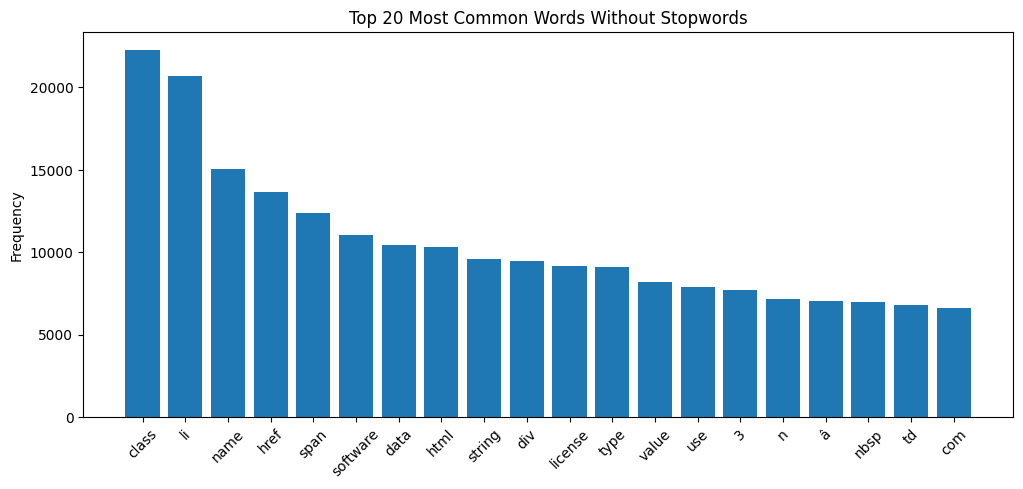

In [ ]:
# without stop words

import matplotlib.pyplot as plt

word_counts = Counter(filtered_sentence)
print(word_counts.most_common(20))

top_n = 20
most_common_words = word_counts.most_common(top_n)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words Without Stopwords')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
#plt.savefig('top_words2.png')
plt.show()

In [ ]:
# unique words

unique_words = set(all_words)
print(f'Number of unique words: {len(unique_words)}')

Number of unique words: 158074


## 2. Loading the model and prompt it


Now we will try to promt the model with data from file prompts_100 (So, the length of the prompt is 100 tokens). As a prompt we will use the first 50 tokents of the sequence.

In [9]:
data_prompts = data_p.copy()
data_counts = data_c.copy()

In [10]:
model = GPTNeoForCausalLM.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

### 2.1 One prompt

In [ ]:
sequence = torch.tensor(torch.from_numpy(data_prompts[199][:prompt_length].astype(int)))
sequence = sequence.reshape(1, -1)
sequence

<ipython-input-121-495f3da0081d>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(torch.from_numpy(data_prompts[199][:prompt_length].astype(int)))


tensor([[  276, 35067,   540,  5317,  5574, 25628,     7,    55,  9514,     8,
          5218,   513,    13,    18,    26,   198,   220,  8925,  1441, 14253,
           276, 35067,   540,    55,     7,    55,  9514,     8,  5218,  1395,
          9783,   198,   220,  8925,  1441, 14253,   276,    55,     7,    55,
          9514,     8,  5218,  1395,  9783,   198,    92,   198,   198, 12417,
          3419,  1391,   198,   220,  2457,  3815,   796,   685, 29710,    16,
         22784,  7308, 29710,    17, 22784,  3834, 29710,    18,  3419, 11208,
           628,   220,  2457,   257,   796,  3815,    58,   600,    13, 29572,
         10786,    15, 11537,    60,   355, 34347,    16,    26,   198,   220,
          2457,   275,   796,  3815,    58,   600,    13, 29572, 10786,    16,
         11537,    60,   355,  7308, 29710,    17,    26,   198,   220,  2457,
           269,   796,  3815,    58,   600,    13, 29572, 10786,    17, 11537,
            60,   355,  3834, 29710,    18,    26,  

In [ ]:
output = model.generate(sequence, max_new_tokens=p, min_new_tokens=p, eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.eos_token_id)
output_d = tokenizer.decode(output[0])

In [ ]:
output_d

"edNullableIntOrDouble(X ignored) => 3.3;\n  dynamic returnBoxedNullableX(X ignored) => X();\n  dynamic returnBoxedX(X ignored) => X();\n}\n\nmain() {\n  final values = [Impl1(), BaseImpl2(), SubImpl3()];\n\n  final a = values[int.parse('0')] as Impl1;\n  final b = values[int.parse('1')] as BaseImpl2;\n  final c = values[int.parse('2')] as SubImpl3;\n  final d = values[int.parse('2')] as Interface;\n\n  a.takePositional(0)\n   .takePositional(1)\n   .takePositional(2)\n   .takePositional(3)\n   .takePositional(4)\n  "

### 2.2 Loop function for the whole dataset

In [34]:
def decode_file(file):

    decoded_data = []

    for ids in tqdm.tqdm(data_prompts):
      decoded_data.append(vocab.decode(ids, skip_special_tokens=True))

    return decoded_data

def generate_output(input_data, n_iter, prompt_length, p, seed):
    result = []

    np.random.seed(seed)
    input_data = input_data.copy()
    np.random.shuffle(input_data)

    for sequence, i in zip(tqdm.tqdm(input_data[:n_iter]), range(1, n_iter + 1)):

      prompt = torch.from_numpy(sequence[:prompt_length].astype(int)).reshape(1, -1)
      output = model.generate(prompt, max_new_tokens=p, min_new_tokens=p, eos_token_id=model.config.eos_token_id,
        pad_token_id=model.config.eos_token_id)

      output_last_p = output.numpy()[0][prompt_length:]
      sequence_last_p = sequence[prompt_length:]

      memorization = 1 if (output_last_p == sequence_last_p).all() else 0

      result.append([sequence, output.numpy()[0], memorization])

      if i % save_every == 0:
        df = pd.DataFrame(result)
        df.to_csv('output_' + str(sequence_length) + '_' + str(i) + '.csv')
        files.download('output_' + str(sequence_length) + '_' + str(i) + '.csv')

    return result

In [35]:
output = generate_output(data_prompts, number_of_iterations, prompt_length, p, seed)

 40%|████      | 4/10 [00:37<00:56,  9.46s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 90%|█████████ | 9/10 [01:30<00:09,  9.87s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


In [ ]:
df = pd.DataFrame(output)
df.to_csv('output_' + str(sequence_length) + '_' + 'final' + '.csv')
files.download('output_' + str(sequence_length) + '_' + 'final' + '.csv')

## Appendix 1

In [ ]:
output_encoded = []
output_decoded = []
counter = 0

for sequence in tqdm.tqdm(data_prompts[:number_of_iterations]):

    prompt = torch.from_numpy(sequence[:prompt_length].astype(int)).reshape(1, -1)

    output = model.generate(prompt, max_new_tokens=p, min_new_tokens=p, eos_token_id=model.config.eos_token_id,
      pad_token_id=model.config.eos_token_id)

    if (output.numpy()[0][prompt_length:] == sequence[prompt_length:]).all():
      counter += 1

    output_d = tokenizer.decode(output[0])
    input_d = tokenizer.decode(sequence)

    print('Counter ', counter)
    print('\n' + 'Input: ' + input_d + '\n' + 'Output: ' + output_d + '\n ---------- \n')

    output_encoded.append(output)
    output_decoded.append(output_d)